In [16]:
#%pip install qiskit qiskit_aer matplotlib pylatexenc

--- Sequential BV (measure-at-end) ---


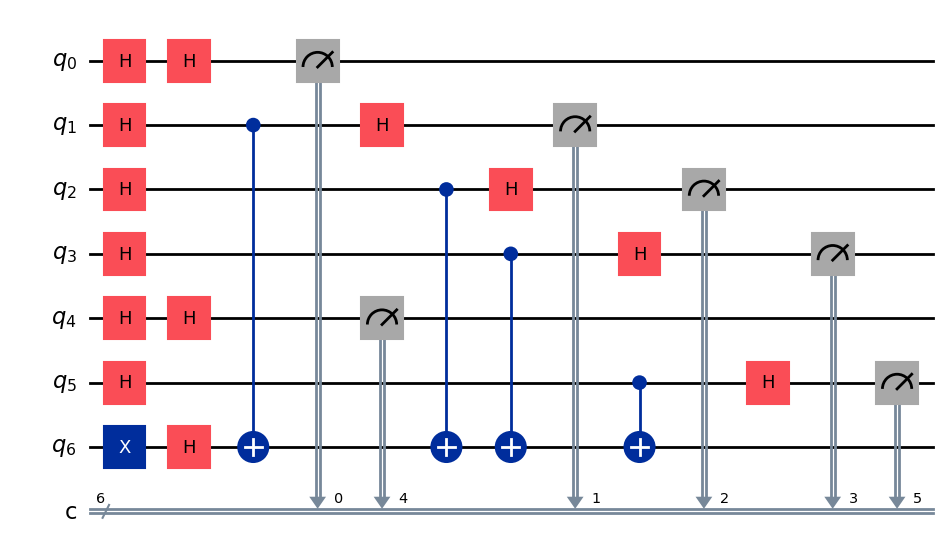

In [17]:
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag
from qiskit.dagcircuit import DAGOpNode
import stim

s = '101110'
n = len(s)
qc_seq = QuantumCircuit(n + 1, n)

# Ancilla prep
qc_seq.x(n)
qc_seq.h(n)

for i in range(n):
    qc_seq.h(i)
    if s[n - 1 - i] == '1':
        qc_seq.cx(i, n)
    qc_seq.h(i)

for i in range(n):
    qc_seq.measure(i, i)

print("--- Sequential BV (measure-at-end) ---")
display(qc_seq.draw('mpl'))


Initial reusable pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 0), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 3), (2, 4), (2, 5), (3, 0), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 5), (4, 6), (5, 0), (5, 4), (6, 0), (6, 4)]

--- Optimized Circuit ---
Depth: 27
Qubits: 7
Reused 5 qubit(s)
Reuse chain: [(0, 1), (4, 5), (0, 2), (0, 3), (0, 4)]


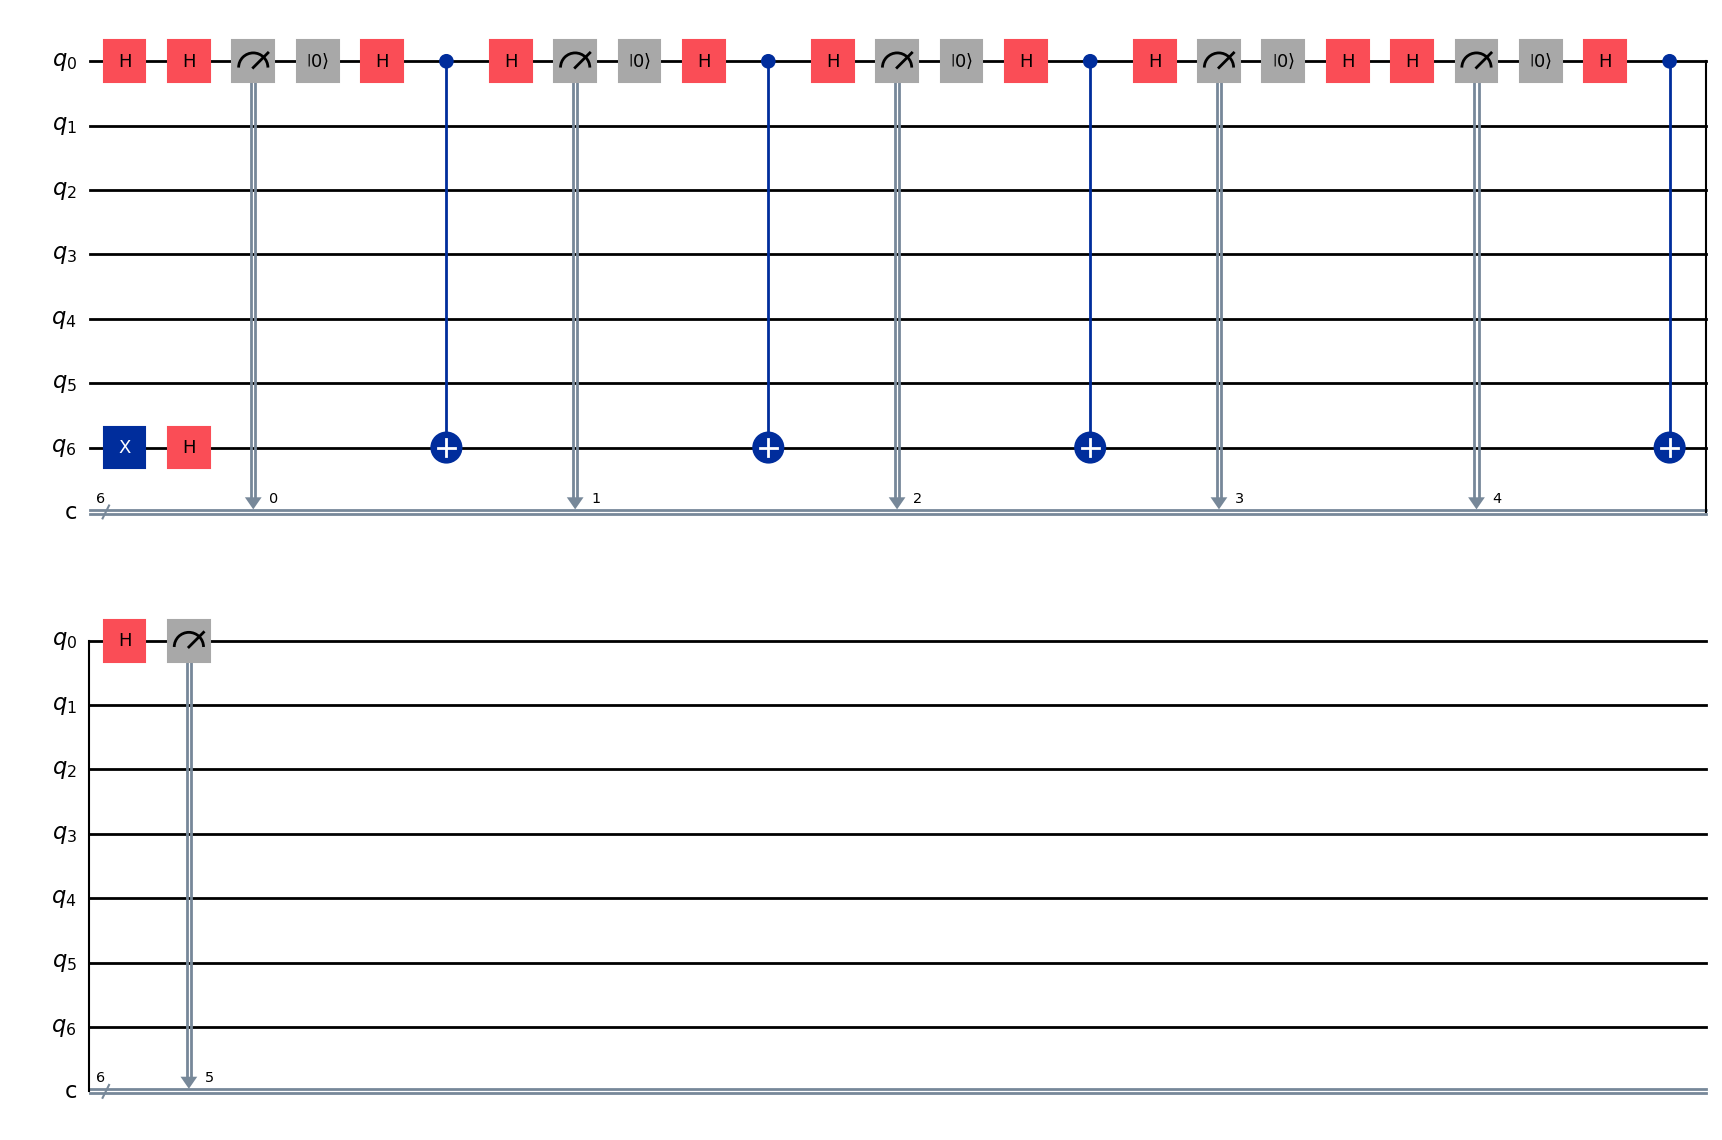

In [18]:
from circuit_analysis import find_qubit_reuse_pairs, modify_circuit, last_index_operation, first_index_operation
import sys

cur_qc = qc_seq.copy()
reuse_pairs = find_qubit_reuse_pairs(cur_qc)
print(f"\nInitial reusable pairs: {reuse_pairs}")
iter_count = 0
chain = []
weight = (1, 1, 1)


while len(reuse_pairs) > 0 and iter_count < len(qc_seq.qubits) - 1:
    depth_diff = sys.maxsize    
    lst_index = last_index_operation(cur_qc)
    fst_index = first_index_operation(cur_qc)
    
    for i in range(len(reuse_pairs)):
        test_qc = cur_qc.copy()
        test_out_qc = modify_circuit(test_qc, reuse_pairs[i])

        if weight[0]*(test_out_qc.depth() - cur_qc.depth()) + weight[1]* lst_index[reuse_pairs[i][0]]+weight[2]*abs(lst_index[reuse_pairs[i][0]] - fst_index[reuse_pairs[i][1]]) < depth_diff:
            depth_diff = test_out_qc.depth() - cur_qc.depth() + 0.5*lst_index[reuse_pairs[i][0]]
            best_pair = reuse_pairs[i]

    # print(f"Best pair: {best_pair}")
    chain.append((best_pair[0], best_pair[1]))
    modified_qc = modify_circuit(cur_qc, best_pair)
    # print(modified_qc)

    reuse_pairs = find_qubit_reuse_pairs(modified_qc)
    cur_qc = modified_qc.copy()
    iter_count += 1
    lst_index = last_index_operation(cur_qc)

print(f"\n--- Optimized Circuit ---")
print(f"Depth: {cur_qc.depth()}")
print(f"Qubits: {cur_qc.num_qubits}")
print(f"Reused {iter_count} qubit(s)")
print(f"Reuse chain: {chain}")
display(cur_qc.draw('mpl'))

TESTING ORIGINAL BV CIRCUIT (before CAQR)

--- Testing Original BV ---
Expected secret string: 101110
Measurement results:
  101110: 1000 (100.0%) ✓
✓ SUCCESS: Circuit correctly identifies secret string!


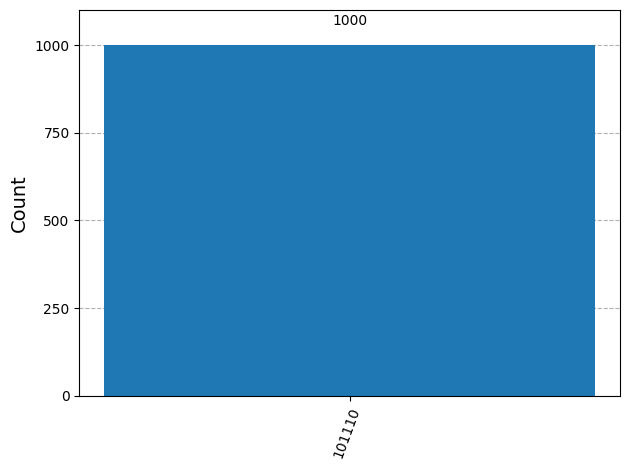


TESTING OPTIMIZED BV CIRCUIT (after CAQR)

--- Testing CAQR Optimized ---
Expected secret string: 101110
Measurement results:
  101110: 1000 (100.0%) ✓
✓ SUCCESS: Circuit correctly identifies secret string!


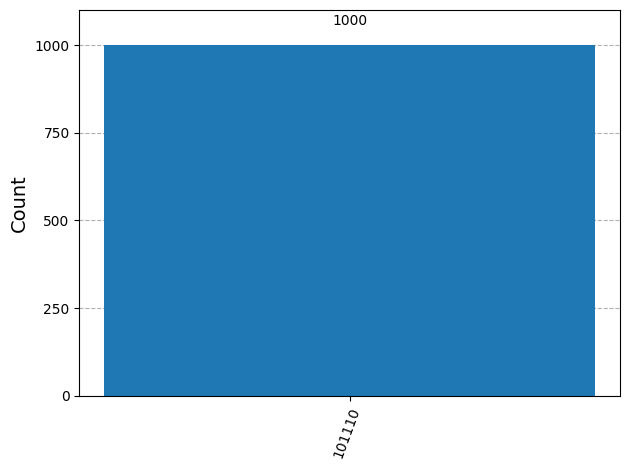

True

In [19]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

def test_bv_circuit(qc, secret_string, circuit_name="Circuit"):
    test_qc = qc.copy()

    simulator = AerSimulator()
    job = simulator.run(test_qc, shots=1000)
    result = job.result()
    counts = result.get_counts()
    
    print(f"\n--- Testing {circuit_name} ---")
    print(f"Expected secret string: {secret_string}")
    print(f"Measurement results:")
    
    most_common = max(counts, key=counts.get)
    
    n = len(secret_string)
    
    for key, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]:
        measured_bits = key[-n:] if len(key) >= n else key
        percentage = 100 * count / 1000
        match = "✓" if measured_bits == secret_string else "✗"
        print(f"  {measured_bits}: {count:4d} ({percentage:5.1f}%) {match}")
    
    # Verify correctness
    result_bits = most_common[-n:] if len(most_common) >= n else most_common
    is_correct = result_bits == secret_string
    
    if is_correct:
        print(f"✓ SUCCESS: Circuit correctly identifies secret string!")
    else:
        print(f"✗ FAILED: Got {result_bits}, expected {secret_string}")
    
    display(plot_histogram(counts))
    
    return is_correct

# Test original BV circuit
print("="*60)
print("TESTING ORIGINAL BV CIRCUIT (before CAQR)")
print("="*60)
test_bv_circuit(qc_seq, s, "Original BV")

# Test optimized circuit
print("\n" + "="*60)
print("TESTING OPTIMIZED BV CIRCUIT (after CAQR)")
print("="*60)
test_bv_circuit(cur_qc, s, "CAQR Optimized")

In [20]:
from qiskit import QuantumCircuit

def qubit_lifetimes_sequential(qc: QuantumCircuit):
    """
    Simple lifetime model:
    - Treat each instruction in qc.data as a time step.
    - For each qubit, record index of first and last instruction that touches it.
    - Lifetime = (last - first + 1) time steps, or 0 if never used.
    """
    n_qubits = qc.num_qubits
    first = [None] * n_qubits
    last = [None] * n_qubits

    # Build a mapping from Qubit object to its integer index
    qubit_index = {qb: i for i, qb in enumerate(qc.qubits)}

    for t, inst in enumerate(qc.data):
        # inst.qubits is a list of Qubit objects
        for qb in inst.qubits:
            qi = qubit_index[qb]
            if first[qi] is None:
                first[qi] = t
            last[qi] = t

    lifetimes = []
    for i in range(n_qubits):
        if first[i] is None:
            lifetimes.append(0)
        else:
            lifetimes.append(last[i] - first[i] + 1)

    return lifetimes

def summarise_lifetimes(qc: QuantumCircuit, name: str):
    lifetimes = qubit_lifetimes_sequential(qc)
    total = sum(lifetimes)
    nonzero = [t for t in lifetimes if t > 0]
    max_life = max(nonzero) if nonzero else 0
    avg_life = sum(nonzero) / len(nonzero) if nonzero else 0.0

    print(f"\n--- {name} ---")
    print("Lifetimes per qubit:", lifetimes)
    print(f"Total lifetime sum: {total}")
    print(f"Max lifetime:       {max_life}")
    print(f"Average lifetime:   {avg_life:.2f}")
    if avg_life > 0:
        print(f"Max / Avg ratio:    {max_life / avg_life:.2f}")
    return lifetimes

lifetimes_orig = summarise_lifetimes(qc_seq, "Original BV")
lifetimes_caqr = summarise_lifetimes(cur_qc, "BV after CaQR")



--- Original BV ---
Lifetimes per qubit: [17, 16, 14, 12, 10, 9, 17]
Total lifetime sum: 95
Max lifetime:       17
Average lifetime:   13.57
Max / Avg ratio:    1.25

--- BV after CaQR ---
Lifetimes per qubit: [27, 0, 0, 0, 0, 0, 27]
Total lifetime sum: 54
Max lifetime:       27
Average lifetime:   27.00
Max / Avg ratio:    1.00


In [21]:
# #THIS IS SO COOKED: THE DOCUMENTATION VERSION IS NOT AVAILABLE TO INSTALL AND THE LATEST VERSION INTRODUCES THIS FUNCTION
# from mqt.qecc.circuit_synthesis.circuit_utils import 

# stim_circuit = (cur_qc)
# print(stim_circuit)

In [22]:
# #THIS IS ALSO GIGA COOKED: ERROR WITHIN THE LIBRARY
# from qiskit_qec.utils import get_stim_circuits


# test_qc_seq = QuantumCircuit(n + 1, n)
# test_qc_seq.h(n)

# for i in range(n):
#     test_qc_seq.h(i)
#     if s[n - 1 - i] == '1':
#         test_qc_seq.cx(i, n)
#     test_qc_seq.h(i)

# for i in range(n):
#     test_qc_seq.measure(i, i)

# print("--- Sequential BV (measure-at-end) ---")
# display(test_qc_seq.draw('mpl'))


# stim_circuit = get_stim_circuits(test_qc_seq)
# print(stim_circuit)

In [23]:
from stim import Circuit

def qiskit_to_stim_circuit(qc: QuantumCircuit) -> Circuit:
    """Convert a Qiskit circuit to a Stim circuit."""
    single_qubit_gate_map = {
        "h": "H",
        "x": "X",
        "y": "Y",
        "z": "Z",
        "s": "S",
        "sdg": "S_DAG",
        "sx": "SQRT_X",
        "measure": "MR",
        "reset": "R",
    }
    stim_circuit = Circuit()
    for gate in qc:
        op = gate.operation.name
        qubit = qc.find_bit(gate.qubits[0])[0]
        if op in single_qubit_gate_map:
            stim_circuit.append_operation(single_qubit_gate_map[op], [qubit])
        elif op == "cx":
            target = qc.find_bit(gate.qubits[1])[0]
            stim_circuit.append_operation("CX", [qubit, target])
        elif op == "barrier":
            stim_circuit.append("TICK")
        else:
            msg = f"Unsupported gate: {op}"
            raise ValueError(msg)
    return stim_circuit


print("\n--- Converting to Stim ---")
stim_circuit = qiskit_to_stim_circuit(cur_qc)

print(f"\n--- Stim Circuit ---")
print(stim_circuit)


--- Converting to Stim ---

--- Stim Circuit ---
X 6
H 6 0 0
MR 0
R 0
H 0
CX 0 6
H 0
MR 0
R 0
H 0
CX 0 6
H 0
MR 0
R 0
H 0
CX 0 6
H 0
MR 0
R 0
H 0 0
MR 0
R 0
H 0
CX 0 6
H 0
MR 0


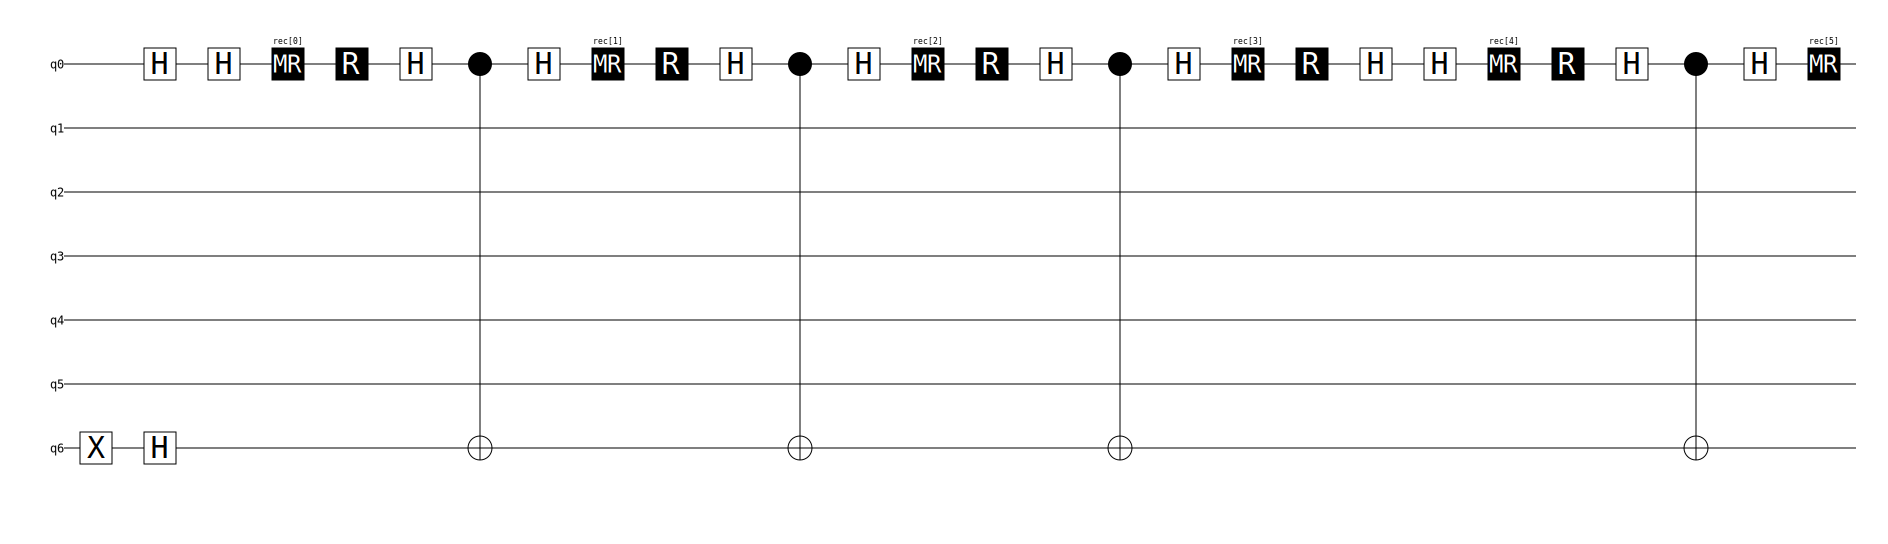

In [24]:
stim_circuit.diagram("timeline-svg")

In [25]:
import stim
import numpy as np

def test_stim_circuit(stim_circuit, secret_string, circuit_name="Stim Circuit"):
    """
    Test a Stim circuit to verify it outputs the correct secret string.
    
    Args:
        stim_circuit: Stim Circuit object
        secret_string: Expected secret string (e.g., '1011')
        circuit_name: Name for display
    
    Returns:
        bool: True if circuit produces correct answer
    """
    print(f"\n--- Testing {circuit_name} ---")
    print(f"Expected secret string: {secret_string}")
    
    # Run simulation
    sampler = stim_circuit.compile_sampler()
    samples = sampler.sample(shots=1000)
    
    # Count measurement outcomes
    n = len(secret_string)
    
    # Convert samples to bitstrings
    results = {}
    for shot in samples:
        # Take the last n measurements and REVERSE for Qiskit ordering
        bitstring = ''.join(str(int(bit)) for bit in shot[-n:])[::-1]  # ← Added [::-1]
        results[bitstring] = results.get(bitstring, 0) + 1
    
    print(f"Measurement results:")
    
    # Sort by count and show top 5
    for bitstring, count in sorted(results.items(), key=lambda x: x[1], reverse=True)[:5]:
        percentage = 100 * count / 1000
        match = "✓" if bitstring == secret_string else "✗"
        print(f"  {bitstring}: {count:4d} ({percentage:5.1f}%) {match}")
    
    # Verify correctness
    most_common = max(results, key=results.get)
    is_correct = most_common == secret_string
    
    if is_correct:
        print(f"✓ SUCCESS: Circuit correctly identifies secret string!")
    else:
        print(f"✗ FAILED: Got {most_common}, expected {secret_string}")
    
    return is_correct

# Test the Stim circuit
print("="*60)
print("TESTING STIM CIRCUIT (after translation)")
print("="*60)
test_stim_circuit(stim_circuit, s, "Translated Stim Circuit")

# Optional: Also check the measurement structure
print(f"\n--- Stim Circuit Measurement Info ---")
print(f"Total measurements in circuit: {stim_circuit.num_measurements}")
print(f"Number of qubits: {stim_circuit.num_qubits}")
print(f"\nCircuit structure:")
print(stim_circuit.diagram("timeline-text"))

TESTING STIM CIRCUIT (after translation)

--- Testing Translated Stim Circuit ---
Expected secret string: 101110
Measurement results:
  101110: 1000 (100.0%) ✓
✓ SUCCESS: Circuit correctly identifies secret string!

--- Stim Circuit Measurement Info ---
Total measurements in circuit: 6
Number of qubits: 7

Circuit structure:
q0: ---H-H-MR:rec[0]-R-H-@-H-MR:rec[1]-R-H-@-H-MR:rec[2]-R-H-@-H-MR:rec[3]-R-H-H-MR:rec[4]-R-H-@-H-MR:rec[5]-
                         |                 |                 |                                 |
q1: ---------------------|-----------------|-----------------|---------------------------------|-------------
                         |                 |                 |                                 |
q2: ---------------------|-----------------|-----------------|---------------------------------|-------------
                         |                 |                 |                                 |
q3: ---------------------|-----------------|--------

In [26]:
# Debug: Show ALL measurement samples
print("\n--- Debug: First 10 measurement samples ---")
sampler = stim_circuit.compile_sampler()
samples = sampler.sample(shots=10)
for i, shot in enumerate(samples):
    all_bits = ''.join(str(int(b)) for b in shot)
    last_4 = ''.join(str(int(b)) for b in shot[-4:])
    first_4 = ''.join(str(int(b)) for b in shot[:4])
    print(f"Shot {i}: ALL={all_bits}, LAST_4={last_4}, FIRST_4={first_4}")


--- Debug: First 10 measurement samples ---
Shot 0: ALL=011101, LAST_4=1101, FIRST_4=0111
Shot 1: ALL=011101, LAST_4=1101, FIRST_4=0111
Shot 2: ALL=011101, LAST_4=1101, FIRST_4=0111
Shot 3: ALL=011101, LAST_4=1101, FIRST_4=0111
Shot 4: ALL=011101, LAST_4=1101, FIRST_4=0111
Shot 5: ALL=011101, LAST_4=1101, FIRST_4=0111
Shot 6: ALL=011101, LAST_4=1101, FIRST_4=0111
Shot 7: ALL=011101, LAST_4=1101, FIRST_4=0111
Shot 8: ALL=011101, LAST_4=1101, FIRST_4=0111
Shot 9: ALL=011101, LAST_4=1101, FIRST_4=0111


In [27]:
import stim

circuit = stim.Circuit()

circuit.append("X", [4])
circuit.append("H", [0, 1, 2, 3, 4])
circuit.append("CNOT", [0, 4])
circuit.append("H", [0])
circuit.append("CNOT", [1, 4])
circuit.append("H", [1])
circuit.append("CNOT", [2, 4])
circuit.append("H", [2])
circuit.append("CNOT", [3, 4])
circuit.append("H", [3])
circuit.append("M", [0, 1, 2, 3])
# circuit.append("H", [0])
# circuit.append("CNOT", [0, 1])

# # Then, the circuit will measure both qubits of the Bell pair in the Z basis.
# circuit.append("M", [0, 1])


circuit.diagram()

q0: -H---@-H-----M:rec[0]----------
         |
q1: -H---|-@-H---M:rec[1]----------
         | |
q2: -H---|-|-@-H-M:rec[2]----------
         | | |
q3: -H---|-|-|-@-H--------M:rec[3]-
         | | | |
q4: -X-H-X-X-X-X-------------------

In [28]:
%pip install --upgrade matplotlib

Note: you may need to restart the kernel to use updated packages.
